Посмотрим одноразмерные ковариационные функции (для которых равномерная выборка одномерна)

Попробуем апрокссимировать гауссовские процессы на основе данных ковариационных функций с помощью гауссовских процессов на основе ядер: exponential , Matern32 , Matern52 , periodic_matern32

In [1]:
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt
%matplotlib inline


def TestFunction(x, p):
    res = (abs (x))**(p+1)
    return res

{'dataplot': [<matplotlib.collections.PathCollection at 0x2237c17be80>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2237c17be48>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2237c18d358>]}

 C:\Users\moroz\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


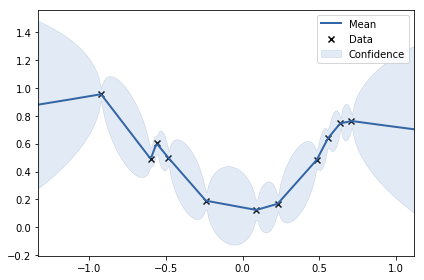

In [2]:
a = np.random.uniform (-1,1,(1,1))
b = TestFunction (a, 0)
for i in range (10):
    X = np.random.uniform (-1,1, (1,1))
    y = TestFunction (X, 0) + np.random.normal(0,0.07)
    a=np.append (a,X)
    b=np.append (b,y)
    
gp_x = a.reshape(a.shape[0], 1)
gp_y = b.reshape(b.shape[0], 1)
kern = GPy.kern.Exponential(1, 1)
model = GPy.models.GPRegression(gp_x, gp_y, kern)
model.optimize()
a = np.random.uniform (0,1,(1,1))
xx = a.reshape(a.shape[0], 1)

model.plot()

Проведем тесты

In [3]:
kern_name = [GPy.kern.Exponential, GPy.kern.Matern32, GPy.kern.Matern52, 
            GPy.kern.PeriodicMatern32, GPy.kern.Minimax, GPy.kern.ExpQuad] #ядра гауссовских процессов


def test (p, k1, i1, m1, ker_name):
#k1 - количество тестов
#i1 - количество точек в обучающей выборке
#m1 - количество точек для подсчёта MAE, MSE
    MAE_exp = []
    MSE_exp = []
    for k in range (k1):
        a=[]
        b=[]
        for i in range (i1):
            X = np.random.uniform (0,1,(1,1))
            y =  TestFunction (X, p)
            a=np.append (a,X)
            b=np.append (b,y)

        gp_x = a.reshape(a.shape[0], 1)
        gp_y = b.reshape(b.shape[0], 1)
        kern_1 = ker_name(1)
        model = GPy.models.GPRegression(gp_x, gp_y, kern_1)
        model.optimize()
        a=[]
        b=[]
        for i in range (m1):
            X = np.random.uniform (0,1,(1,1))
            y = TestFunction (X, p)
            a=np.append (a,X)
            b=np.append (b,y)

        gp_xx = a.reshape(a.shape[0], 1)
        gp_yy=model.predict(gp_xx)
        c=gp_yy[0]
        MAE_exp=np.append(MAE_exp, MAE(b,c))
        MSE_exp=np.append(MSE_exp, MSE(b,c))
    return MAE_exp, MSE_exp

In [4]:
import warnings
import time
warnings.filterwarnings('ignore')

d1 = pd.DataFrame(columns=['Name','MSE_exp', 'MSE_mt32', 'MSE_mt52',  'MSE_pmt32', 'MSE_Minimax', 'MSE_ExpQuad'])
d2 = pd.DataFrame(columns=['Name','Exponential', 'Matern32', 'Matern52',  'PeriodicMatern32', 'Minimax', 'ExpQuad'])

i=0
start = time.time()
for k in range (8):
    for m in range (6):
        MSE_error=[str(k)+str(m)]
        MAE_error=[str(k)+str(m)]
        print (k, '', m+4)
        for ker_name in kern_name:
            text = test (m+4, 50, 10 + k*3,100, ker_name)
            MAE_1 = text[0]
            MSE_1 = text[1]
            MAE_=np.mean (MAE_1)
            MSE_=np.mean (MSE_1)
            MSE_error = np.append (MSE_error,MSE_)
            MAE_error = np.append (MAE_error,MAE_)
        d1.loc[i] = MSE_error
        d2.loc[i] = MAE_error
        i=i+1
end = time.time()
work_time = end - start
print ('Время работы: ', work_time)

0  4
0  5
0  6
0  7
0  8
0  9
1  4
1  5
1  6
1  7
1  8
1  9
2  4
2  5
2  6
2  7
2  8
2  9
3  4
3  5
3  6
3  7
3  8
3  9
4  4
4  5
4  6
4  7
4  8
4  9
5  4
5  5
5  6
5  7
5  8
5  9
6  4
6  5
6  6
6  7
6  8
6  9
7  4
7  5
7  6
7  7
7  8
7  9
Время работы:  3969.928476333618


In [5]:
n = int(((d2['Exponential']).shape)[0])
print (n)

48


In [6]:
d1.to_csv('p5-10_MSE.csv', sep='\t')
d2.to_csv('p5-10_MAE.csv', sep='\t')

Посмотрим на кривые Долана-Мора

По определению, по оси абцисс данных графиков откладывается величина p равная отношению ошибки рассматриваемого (i-го) аппроксиматора к минимальной ошибке среди всех методов на конкретной задаче.
По оси ординат откладывается доля задач, на которых ошибка метода, нормированная на минимальное значение ошибки среди всех методов, не превосходит величины p.

In [7]:
del d2['Name']

In [8]:
d2

,Exponential,Matern32,Matern52,PeriodicMatern32,Minimax,ExpQuad
0,0.0358626072641823,0.008289470534668903,0.008581286822920359,0.006016674421414582,0.007339343594343875,0.006752247617002082
1,0.03324124285539432,0.018503513923088383,0.0066435519229795445,0.007013678659388574,0.014904972096376068,0.004546530160336776
2,0.04038745726109441,0.013447781859095951,0.00826135559036542,0.00696573616607498,0.015707331145897,0.009631903703427888
3,0.03772771414249222,0.01526336318281556,0.01569875866155021,0.013782312794866435,0.022083162020544694,0.006895286991787154
4,0.03244632851343818,0.02232423576467024,0.01491724857632651,0.015570999977657658,0.03847606435627985,0.017410445400962187
5,0.03912763709138044,0.02452396818145119,0.024646594293736914,0.02750520793321714,0.030531693475544675,0.0254149923588293
6,0.020099288329257798,0.006494483025385177,0.0018117985191263145,0.0015852961583000288,0.0024740896532297278,0.0010994270535215644
7,0.023120901844183774,0.008969026351522889,0.0039052168505540603,0.0033166795062340893,0.00200477217033267,0.0010885579690906124
8,0.02228647982408317,0.00825036196472056,0.007665423039299006,0.008164998880424495,0.005285595625558307,0.005645942337686533
9,0.024726753254670726,0.01052916569051982,0.00390287914647923,0.003267707691634319,0.007269060089321922,0.0026810892790096793


In [9]:
Names = ['Exponential', 'Matern32', 'Matern52',  'PeriodicMatern32', 'Minimax', 'ExpQuad']

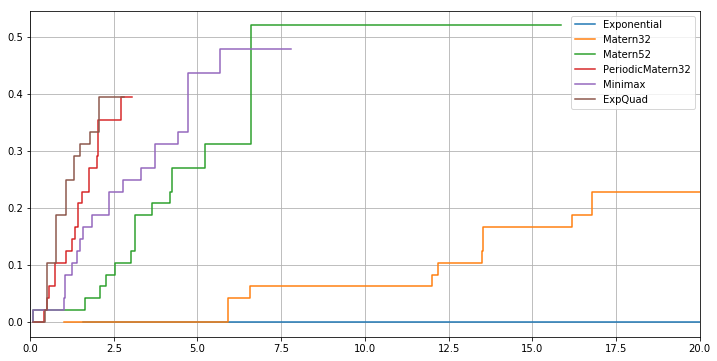

In [13]:
import pylab
plt.figure(figsize=(12, 6))

for name in Names:
    x=[]
    for i in range(n):
        x=np.append(x,float(d2[name][i]) / float(d2.iloc[i].min()))
    y=[]
    x=sorted(x)
    for ab in x:
        m=0
        for i in range(n):
            if (float(d2[name][i]) / float((d2.min()).min())) < ab:
                m=m+1
        y=np.append (y,m)
    y=y/n
    plt.step (x,y, label = name)
    plt.legend()
    print ('')
plt.xlim(0,20)
plt.grid()
pylab.savefig('Test3_p5-10_2.png')